In [1]:
import os
import pydicom
import cv2
import glob

import multiprocessing as mp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont

In [2]:
# The following script was used to generate the images in this dataset
# Note that a small number of images failed due to issues with the pixel data

# Directories

dir_dcm = './stage2/stage_2_train_images/'
dir_img = './stage2/train512/'

# Functions

def window_image(img, window_center, window_width, intercept, slope):
    """
    https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing
    """
    img = (img * slope + intercept)
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img[img < img_min] = img_min
    img[img > img_max] = img_max

    return img


def get_first_of_dicom_field_as_int(x):
    """
    https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing
    """
    # get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)


def get_windowing(data):
    """
    https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing
    """
    dicom_fields = [data[('0028', '1050')].value,  # window center
                    data[('0028', '1051')].value,  # window width
                    data[('0028', '1052')].value,  # intercept
                    data[('0028', '1053')].value]  # slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

def convert_to_png(dcm_in):

    dcm = pydicom.dcmread(dcm_in)
    window_center, window_width, intercept, slope = get_windowing(dcm)
    img = pydicom.read_file(dcm_in).pixel_array
    img = window_image(img, window_center, window_width, intercept, slope)
    #cv2.imwrite(os.path.join(dir_img, os.path.basename(dcm_in)[:-3] + 'png'), img)
    return img


In [3]:
a = os.listdir(dir_dcm)

In [4]:
a[0]

'ID_df267c51c.dcm'

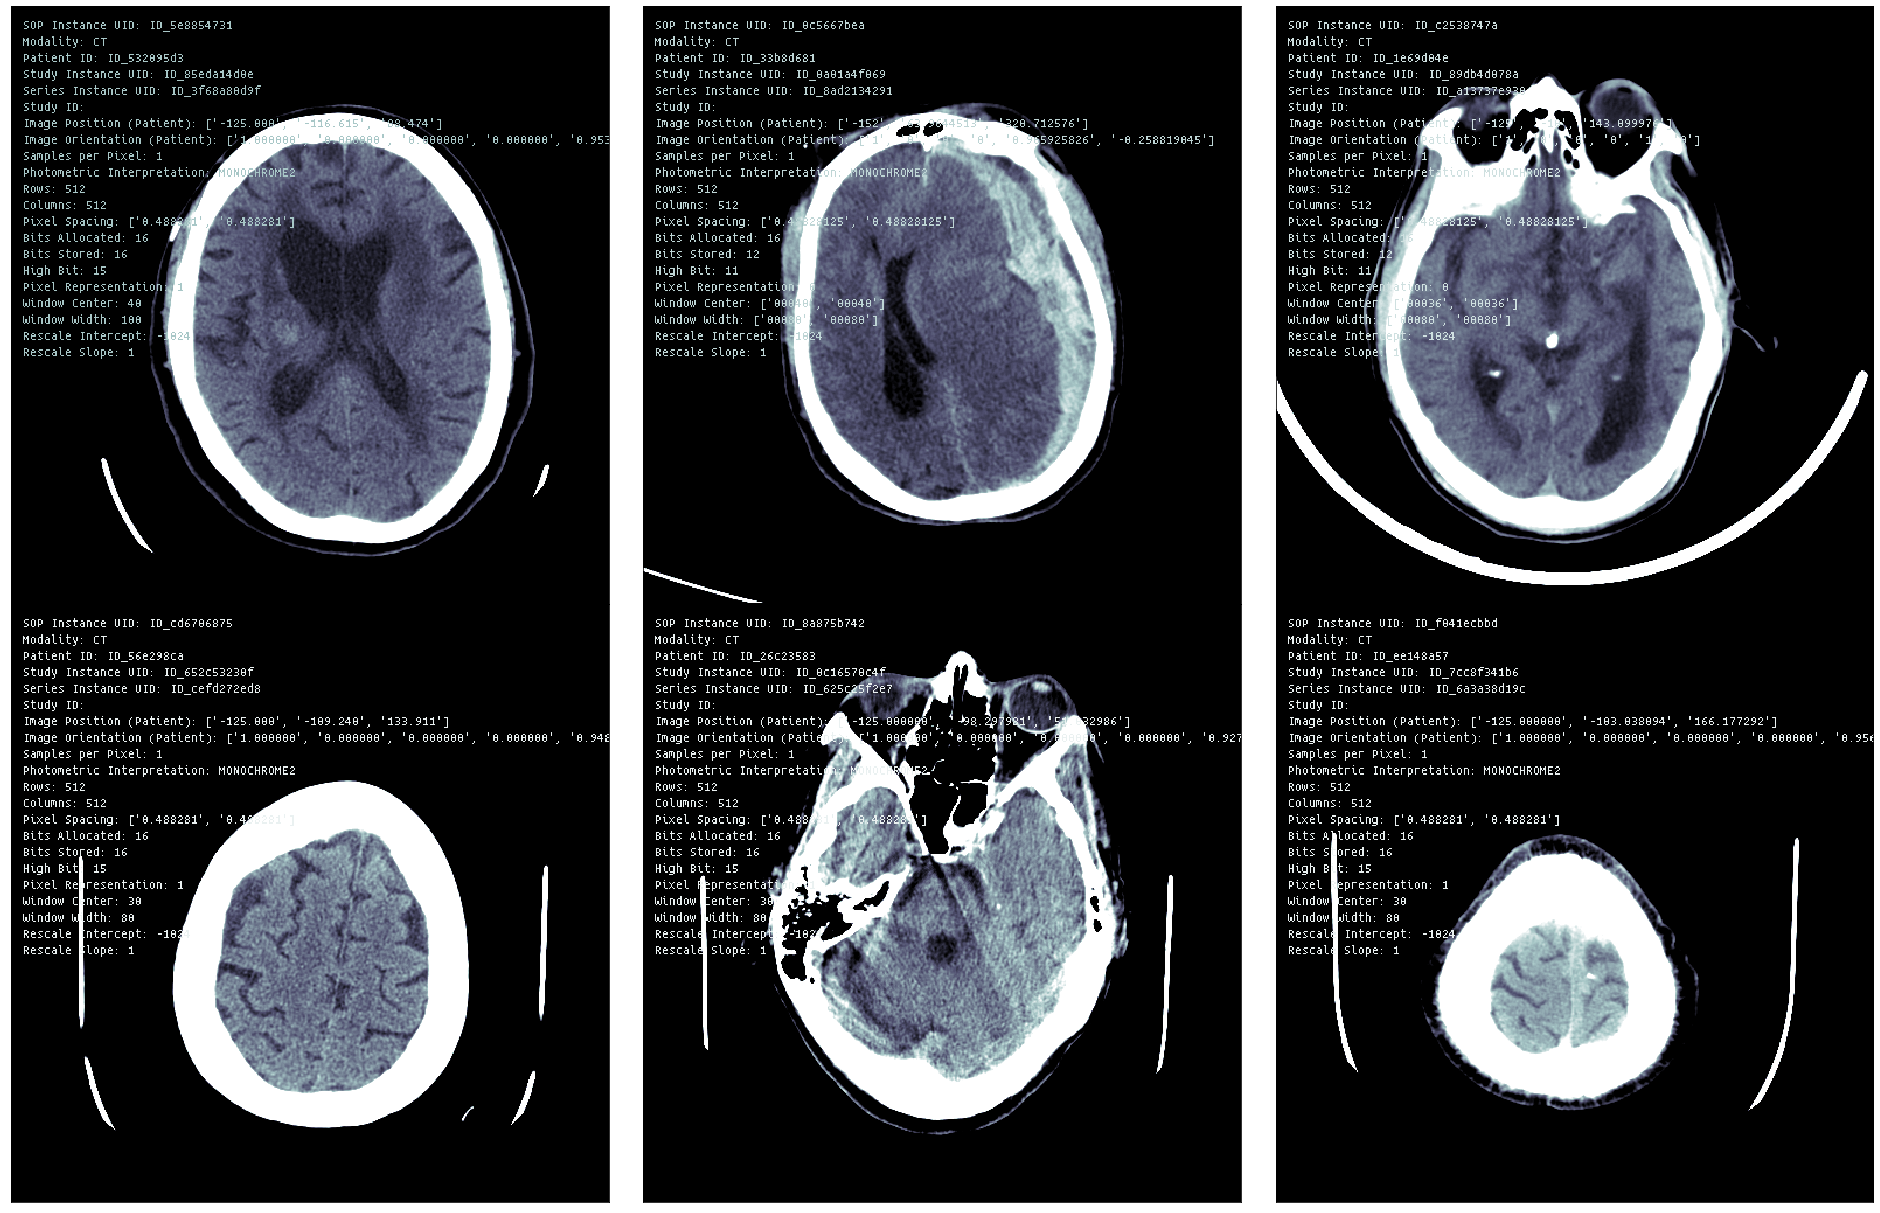

In [7]:
dicom_info = True

fig=plt.figure(figsize=(34, 22))
columns = 3; rows = 2
for i in range(1, columns*rows +1):
    dcm = dir_dcm + a[i]
    dicom = pydicom.dcmread(dcm)
    ds1 = convert_to_png(dcm)
    ds = Image.fromarray(ds1)
    ds_ = ImageDraw.Draw(ds)
    content = ''
    for j in list(dicom.keys())[:-1]:
        content += '%s: %s \n'%(dicom[j].name, dicom[j].value)
    if not dicom_info:
        content=''
    ds_.text(
        (10,10),
        "%s"%(content),fill=65,
        font = ImageFont.truetype(
            '/usr/share/fonts/truetype/ubuntu-font-family/UbuntuMono-R.ttf',
            12
        )
    )
    ds = np.array(ds)
    #print('./display/' + a[i].split('.')[0] + 'png')
    #break
    cv2.imwrite('./display/' + a[i].split('.')[0] + '.jpg', ds)
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(wspace =0, hspace =0)
    plt.imshow(ds, cmap=plt.cm.bone)
    fig.add_subplot